In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
from catboost import Pool, CatBoostClassifier
from utils.get_embeddings import *

## Попробуем обучить catboost на классификацию текстов

Под капотом там используется w2v для текстов

In [2]:
df = load_df(os.path.join('data', 'train_spam.csv'))
df

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
...,...,...
16273,spam,if you are interested in binary options tradin...
16274,spam,dirty pictureblyk on aircel thanks you for bei...
16275,ham,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...


In [3]:
df['text_type'] = df['text_type'].apply(lambda x: {'ham': 0, 'spam': 1}[x])

<Axes: >

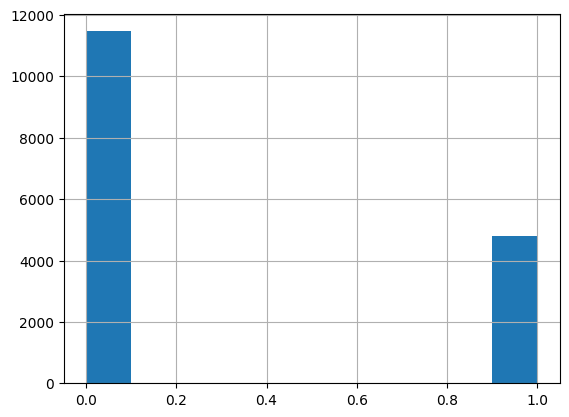

In [4]:
df['text_type'].hist()

Для того, чтобы учесть баланс классов, в параметры кэтбуста будем передавать параметр 'auto_class_weights': 'Balanced'

In [5]:
text_features = ['text']

In [6]:
X = df['text']
y = df['text_type']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.25, random_state=42)

In [8]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [9]:
def fit_catboost(X_train, X_test, y_train, y_test, catboost_params={}, verbose=100):
    learn_pool = Pool(
        data=X_train,
        label=y_train,
        text_features=[0])
    test_pool = Pool(
        data=X_test,
        label=y_test,
        text_features=[0])

    catboost_default_params = {
        'iterations': 1000,
        'loss_function': 'Logloss',
        'l2_leaf_reg': 5,
        'learning_rate': 0.3,
        'eval_metric': 'AUC',
        'task_type': 'GPU',
        'depth': 8,
        'langevin': True,
        'auto_class_weights': 'Balanced',
        'score_function': 'NewtonCosine'
    }
    
    catboost_default_params.update(catboost_params)
    
    model = CatBoostClassifier(**catboost_default_params)
    model.fit(learn_pool, eval_set=test_pool, verbose=verbose)

    return model

In [10]:
fit_catboost(X_train, X_test, y_train, y_test)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9417287	best: 0.9417287 (0)	total: 56.4ms	remaining: 56.4s
100:	test: 0.9848028	best: 0.9848092 (95)	total: 5.33s	remaining: 47.5s
200:	test: 0.9860601	best: 0.9860601 (200)	total: 10.5s	remaining: 41.6s
300:	test: 0.9856557	best: 0.9861613 (230)	total: 15.9s	remaining: 37s
400:	test: 0.9856214	best: 0.9861613 (230)	total: 21.8s	remaining: 32.5s
500:	test: 0.9853954	best: 0.9861613 (230)	total: 27.4s	remaining: 27.3s
600:	test: 0.9852453	best: 0.9861613 (230)	total: 32.8s	remaining: 21.7s
700:	test: 0.9850544	best: 0.9861613 (230)	total: 38.1s	remaining: 16.2s
800:	test: 0.9846385	best: 0.9861613 (230)	total: 43.2s	remaining: 10.7s
900:	test: 0.9845344	best: 0.9861613 (230)	total: 48.6s	remaining: 5.34s
999:	test: 0.9843416	best: 0.9861613 (230)	total: 53.9s	remaining: 0us
bestTest = 0.9861612618
bestIteration = 230
Shrink model to first 231 iterations.


In [11]:
from catboost.text_processing import Tokenizer
import nltk
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
simple_tokenizer = Tokenizer()

In [12]:
tokenized_train = [simple_tokenizer.tokenize(x) for x in X_train.tolist()]
tokenized_test = [simple_tokenizer.tokenize(x) for x in X_test.tolist()]

In [13]:
lemmatized_tokenized_train = [[lemmatizer.lemmatize(token) for token in el] for el in tokenized_train]
lemmatized_tokenized_test = [[lemmatizer.lemmatize(token) for token in el] for el in tokenized_test]

In [14]:
lemmatized_tokenized_train_text = [' '.join(tokens) for tokens in lemmatized_tokenized_train]
lemmatized_tokenized_test_text = [' '.join(tokens) for tokens in lemmatized_tokenized_test]

In [15]:
X_train = pd.DataFrame(X_train, columns=['text'])
X_test = pd.DataFrame(X_test, columns=['text'])

In [16]:
X_train['text'] = lemmatized_tokenized_train_text
X_test['text'] = lemmatized_tokenized_test_text

In [17]:
fit_catboost(X_train, X_test, y_train, y_test)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9450034	best: 0.9450034 (0)	total: 50.1ms	remaining: 50.1s
100:	test: 0.9865028	best: 0.9865600 (90)	total: 5.19s	remaining: 46.2s
200:	test: 0.9870403	best: 0.9870403 (200)	total: 10.3s	remaining: 41s
300:	test: 0.9870445	best: 0.9872770 (240)	total: 15.7s	remaining: 36.6s
400:	test: 0.9872544	best: 0.9872797 (395)	total: 21.1s	remaining: 31.6s
500:	test: 0.9863695	best: 0.9872797 (395)	total: 26.7s	remaining: 26.6s
600:	test: 0.9860496	best: 0.9872797 (395)	total: 32.3s	remaining: 21.4s
700:	test: 0.9856982	best: 0.9872797 (395)	total: 37.6s	remaining: 16s
800:	test: 0.9854755	best: 0.9872797 (395)	total: 43.1s	remaining: 10.7s
900:	test: 0.9849737	best: 0.9872797 (395)	total: 48.3s	remaining: 5.31s
999:	test: 0.9848198	best: 0.9872797 (395)	total: 53.5s	remaining: 0us
bestTest = 0.9872796834
bestIteration = 395
Shrink model to first 396 iterations.
